# Statistical Machine Learning

### K-Nearest Neighbors

K-Nearest Neighbors (KNN) is a simple learning algorithm that can be used in classificatin or regression. Here the working process if you want to predict the response variable from a new record:

1. From the training set, select the K closest records from the new record:
    * This can be done by using euclidian or manhanttan distance
2. For **classification**:
    * count the majority class among the K records selected in 1. 

2. for **regression**:
    * Take the average value of the K records selected in 1.

3. Attribute the result of 2. to the new record

#### Applications

As it can target numerical and categorical response, the K-nearest neighboors can be used in a various of field:
* Finance: For credit scoring and predicting stock prices by comparing with historical data.
* Healthcare: For classifying risk categories based on patient records and diagnosing patients based on symptoms that are similar to previous cases.
* Recommendation Systems: Recommending products like books, movies, or songs to users by finding similar items liked by users in the same neighborhood.

However, this method offers limitated performances and is often prefered as a first stage in predictive modeling.
Indeed, the new predictor is in fact used to enrich the dataset for a more complex model.

#### Limitations
* Feature Scaling Dependency
    * KNN requires features to be scaled uniformly because it uses distance calculations. Unscaled features can disproportionately influence results.
* Choice of 'K'
    * Choosing the right 'K' is critical. Too small a 'K' can lead to overfitting, while too large a 'K' might cause underfitting. Optimal selection typically requires testing and validation.
* Numerical Form Features
    * KNN operates only with numerical data, necessitating preprocessing like encoding for categorical data, which can increase complexity and introduce bias.

#### Example 

 Here, I first optimize the number of neighbors for a KNN classifier using Youden's index, then use the optimized KNN to generate probabilities that are added as a new feature into the dataset. Finally, I use this enriched dataset to train a logistic regression model. I will define a function that encompasses:

1. Preprocessing Setup
    * Identify categorical and numerical columns.  
    * Apply one-hot encoding to categorical variables and standardization to numerical variables.   
2. Pipeline Construction
    * Integrate the preprocessing steps, SMOTE for handling class imbalance, and a placeholder for the classifier.
3. Data Splitting
    * Divide the data into training and testing sets.
4. Model Training and Evaluation
    * Fit the model on the training data and then use it to make predictions on the test set. 
    * Calculate and print key metrics such as accuracy, precision, recall, and specificity.

Then I will optimize the number of neighbors (k) that balance between sensitivity and specificity. For the optimal KNN model, I will calculate and add the probability of class membership as a new feature to the original dataset. Finally, I will retrain logistic regression models on both the enhanced dataset (with new probabilities) and the original dataset to compare the impact of this additional feature on performance.


In [37]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("cleaned_data.csv")



def train_evaluate_model(df,classifier,opt=False):
    #1. Preprocessing Setup
    categories = df.select_dtypes(include="object").columns
    numerical = df.select_dtypes(include="float64").columns
  
    preprocessor = ColumnTransformer(transformers=[('cat',OneHotEncoder(),categories)
                                               ,('num',StandardScaler(),numerical)])
   #2. Pipeline Construction
    pipe = ImbPipeline(steps=[('preprocessor',preprocessor)
                          ,('imbalance',SMOTE(random_state=42))
                          ,('classifier',classifier)
    
    ])

    X = df.drop("stroke",axis=1)
    y = df["stroke"]
    
    #3. Data Splitting
    X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.2,random_state=2)

    #4. Model Training and Evaluation
    model = pipe.fit(X_train,y_train)
    y_predict = model.predict(X_test)

  # Evaluate the model
    cm = confusion_matrix(y_test, y_predict)
    df_cm = pd.DataFrame(cm, index=["No stroke", "Stroke"], 
                         columns=["Predicted no stroke", "Predicted stroke"])
    accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    tpr = cm[1, 1]/(cm[1,0]+cm[1,1])
    fpr = cm[0, 1]/(cm[0,0]+cm[0,1])
    if not opt:
      print(f"Confusion Matrix:\n", df_cm)
      print(f"Accuracy: {accuracy:.2f}")
      print(f"Precision: {precision:.2f}")
      print(f"Recall: {recall:.2f}")
      print(f"Specificity: {specificity:.2f}")

    return tpr - fpr,model


In [31]:
# 5. Optimize
best_k = 0
best_youden = 0
for k in range(1, 100):
    youden, _ = train_evaluate_model(df, KNeighborsClassifier(n_neighbors=k), opt=True)
    if youden > best_youden:
        best_k = k
        best_youden = youden

print(f"The optimized number of neighbors is: {best_k}")

# Train and use optimal KNN
print("Optimal KNN ")

_, opt_knn_model = train_evaluate_model(df, KNeighborsClassifier(n_neighbors=best_k))
X = df.drop("stroke", axis=1)

# This might need adjustment based on whether the `model` supports `predict_proba`
df['knn_prob'] = [x[1] for x in opt_knn_model.predict_proba(X)]

# Train Logistic Regression with KNN probabilities
print("Logistic Regression with KNN probabilities")
_, _ = train_evaluate_model(df, LogisticRegression(max_iter=1000))

# Train Logistic Regression on original data
print("Logistic Regression on original data")
_, _ = train_evaluate_model(df.drop('knn_prob', axis=1), LogisticRegression(max_iter=1000))

The optimized number of neighbors is: 46
Optimal KNN 
Confusion Matrix:
            Predicted no stroke  Predicted stroke
No stroke                  647               292
Stroke                       7                32
Accuracy: 0.69
Precision: 0.10
Recall: 0.82
Specificity: 0.69
Logistic Regression with KNN probabilities
Confusion Matrix:
            Predicted no stroke  Predicted stroke
No stroke                  762               177
Stroke                      17                22
Accuracy: 0.80
Precision: 0.11
Recall: 0.56
Specificity: 0.81
Logistic Regression on original data
Confusion Matrix:
            Predicted no stroke  Predicted stroke
No stroke                  703               236
Stroke                      10                29
Accuracy: 0.75
Precision: 0.11
Recall: 0.74
Specificity: 0.75


* KNN Model: 
    * High recall indicates a good ability to identify positive cases, but a very low precision suggests a high number of false positives. This model might be preferred in scenarios where missing a positive case has severe consequences.
* Logistic Regression with KNN Probabilities: 
    * Shows an overall best balance with the highest accuracy and specificity. This model might be the best choice when overall performance across all metrics is considered.
* Logistic Regression on Original Data: 
    * Exhibits a good recall (slightly lower than KNN but higher than logistic regression with KNN probabilities) and middle-ground accuracy. This might be a preferred model if the detection of more positive cases is prioritized over reducing false positives but with a better accuracy than KNN alone.

### Tree models

Tree models, such as decision trees, are predictive models that use a recursive partitioning algorithm to split data into progressively smaller subsets. This division is driven by a series of binary decisions that effectively separate the dataset into more homogeneous groups with respect to the target variable (like a classification label or regression value). Each split in the tree is based on the attribute that best separates the data into these groups, assessed by measuring homogeneity through statistical measures such as Gini impurity, entropy, or variance reduction.


#### Application

Decision making, healthcare, financial analysis etc, because of:
* **Interpretability**: 
    * Tree models are easy to understand and explain, making them ideal for businesses that require transparency in decision-making processes.
* **Versatility**: 
    * They handle both numerical and categorical data, accommodating the diverse data types found in business environments.
* **Complex Relationship Modeling**: 
    * Trees effectively capture the non-linear interactions between different medical factors, crucial for accurate diagnostics and prognostics.

#### Limitations


* **Overfitting**: 
    * Particularly with deep trees, where models fit too closely to the noise in the training data instead of capturing the underlying pattern.
    * Implementing pruning techniques helps by removing sections by removing parts of the tree that provide little power in predicting the target variable.
* **Instability**: 
    * Small changes in data can result in significantly different trees, making models less reliable.
    * Using ensemble methods like bagging and Random Forests can stabilize predictions. 


#### Example 

Here, I will train a decision tree to classify patients as having a stroke or not, based on all the features of the dataset. For this, I will use the previously created function 'train_evaluate_model'. Then, I will plot the decision tree.


Confusion Matrix:
            Predicted no stroke  Predicted stroke
No stroke                  711               228
Stroke                      11                28
Accuracy: 0.76
Precision: 0.11
Recall: 0.72
Specificity: 0.76
Feature names: ['gender_Female', 'gender_Male', 'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural', 'Residence_type_Urban', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'age', 'avg_glucose_level', 'bmi']


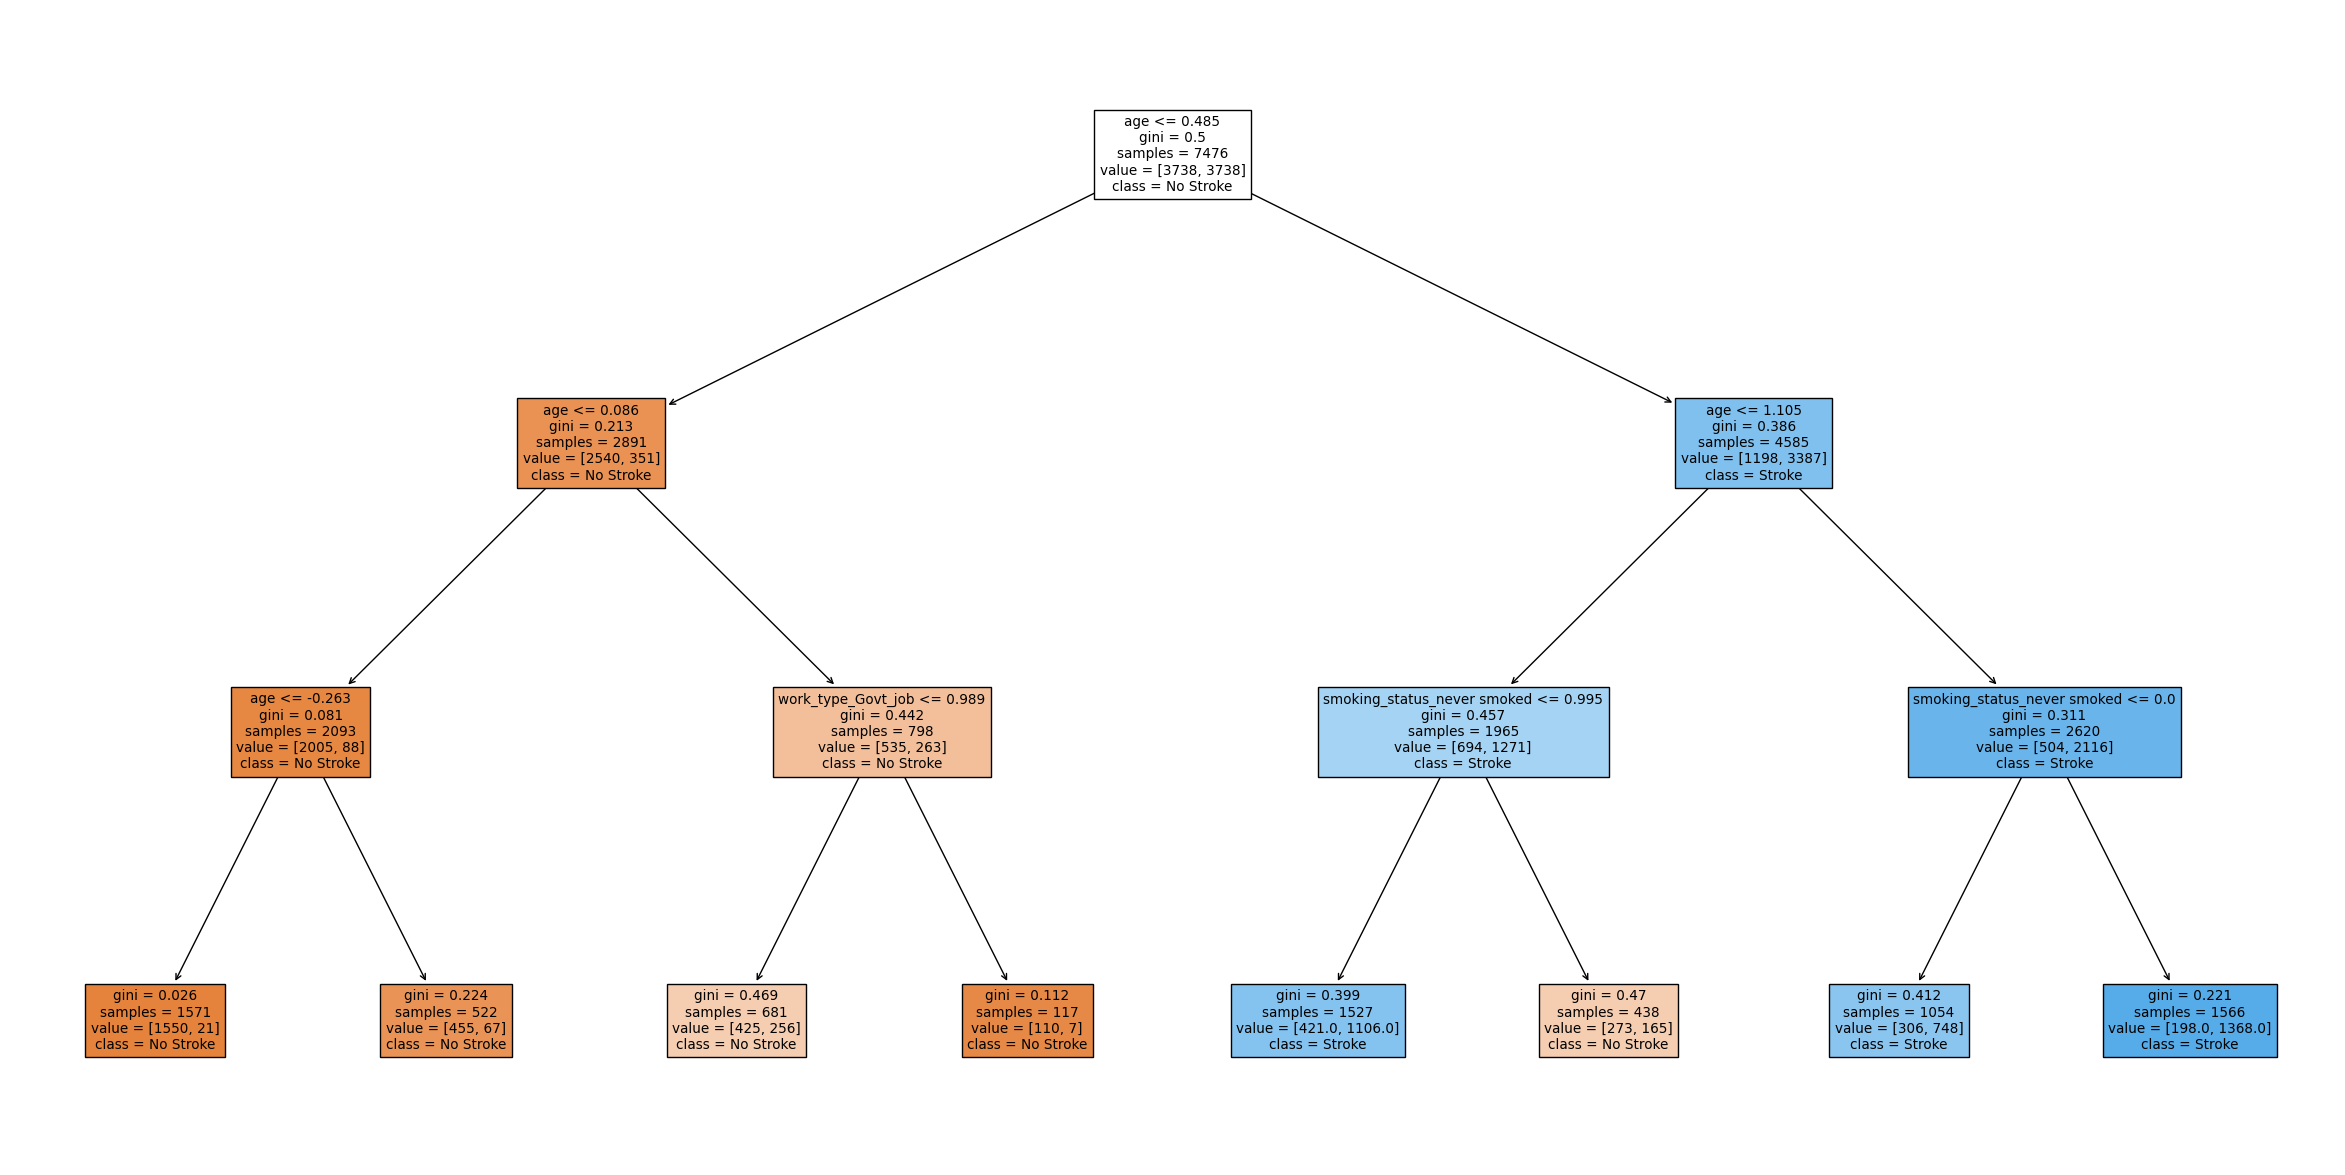

In [32]:
from sklearn.tree import DecisionTreeClassifier
# Load data and train model
df = pd.read_csv("cleaned_data.csv")
df = df.drop("id", axis=1).copy()

# Train model and evaluate the model
_ , model = train_evaluate_model(df, DecisionTreeClassifier(max_depth=3,random_state=42))

# Extract feature names after preprocessing
categorical_columns = df.select_dtypes(include='object').columns
numerical_columns = df.select_dtypes(include=['float64']).columns
cat_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_columns)
num_feature_names = numerical_columns  # Directly use numerical column names
feature_names = list(cat_feature_names) + list(num_feature_names)
print("Feature names:", feature_names)

# Plot the decision tree
plt.figure(figsize=(30, 15))  # Set the plot size
plot_tree(model.named_steps['classifier'], filled=True, feature_names=feature_names, class_names=['No Stroke', 'Stroke'])
plt.show()

To improve performances, various strategies can be employed: optimizing the model's complexity, adjusting imbalance handling techniques, experimenting with different thresholds for classification, and potentially using ensemble methods for better predictive performance.

### Bagging and Random Forest

Bagging (Bootstrap Aggregating) is a powerful ensemble learning technique used to improve the stability and accuracy of machine learning algorithms. The fundamental concept behind bagging is to create multiple models (often of the same type), where each model is trained on a different subset of the dataset. These subsets are created using bootstrap sampling, which involves randomly selecting samples from the original dataset with replacement.

In bagging, the final prediction is made by aggregating the predictions from all models. This is typically done through voting for classification tasks or averaging for regression tasks. The aggregation helps reduce variance and makes the model less likely to overfit, thus enhancing the predictive performance on unseen data.

Random Forest is a refinement and an extension of the bagging technique applied specifically to decision trees. In a Random Forest, each tree in the ensemble is trained on a different bootstrap sample of the dataset, similar to basic bagging. However, Random Forest introduces an additional element of randomness by selecting only a subset of features at each split in the decision tree. This approach not only helps in reducing variance further but also aids in decorrelating the trees, which enhances the overall model’s accuracy.

#### Application


* Financial Sector
    * Used for fraud detection, credit scoring, and risk management.
* Healthcare
    * Employed in disease prediction, patient classification, and medical research for identifying critical risk factors.
* Retail and E-Commerce
    * Applied in customer segmentation, inventory forecasting, and recommendation systems to enhance customer experience.
* Feature ingeenering
    * The importance of the features can be assessed by evaluating the decrease of accuracy or of Giny impurity.



#### Limitation


* Computational Resources
    * Training multiple models on large datasets requires substantial computational power and memory, which can be a bottleneck in resource-constrained environments.
* Model Interpretability
    * While individual trees are straightforward to understand, interpreting an entire forest can be challenging due to the complexity added by numerous trees and random feature selection.
* Performance on Sparse Data
    * These methods might not perform as well with high-dimensional sparse data, such as text data, where other specialized techniques like linear models or gradient boosting might be more effective.

#### Example

Here I will use random forest method to classify patient into stroke and non stroke categories. For that, I will use all the features of the dataset and then evaluate their performance with the decresing accuracy method. Here's the steps:
1. Define the model and the preprocessing steps
    * Set the model to RandomForestClassifier
    * Identify categorical and numerical columns.  
    * Define ColumnTransformer with one-hot encoding to categorical variables and standardization to numerical variables.   
2. Split the data and preprocess the training and test sets separately
    * Divide the data into training and testing sets.
    * Preprocessing the data separatly allows to avoid leakage of information
3. Train the model with the training set and evaluate over the test set
* Fit the model on the training data and then use it to make predictions on the test set. 
* Calculate and print key metrics such as accuracy, precision, recall, and specificity
4. Evaluate the feature importance
    * Retrieve the features name after one hot encoding and concatenate with the numerical variable names.
    * Loop over the column names. At each iteration shuffle the values of the corresponding column and evaluate the accuracy.
    * Calculate the percentage change in accuracy due to the permutation of a feature. 





Confusion Matrix with RandomForestClassifier(min_samples_leaf=100, n_estimators=500):
            Predicted no stroke  Predicted stroke
No stroke                  715               224
Stroke                      13                26
Accuracy: 0.76
Precision: 0.10
Recall: 0.67
Specificity: 0.76


Text(0.5, 1.0, 'Feature importance')

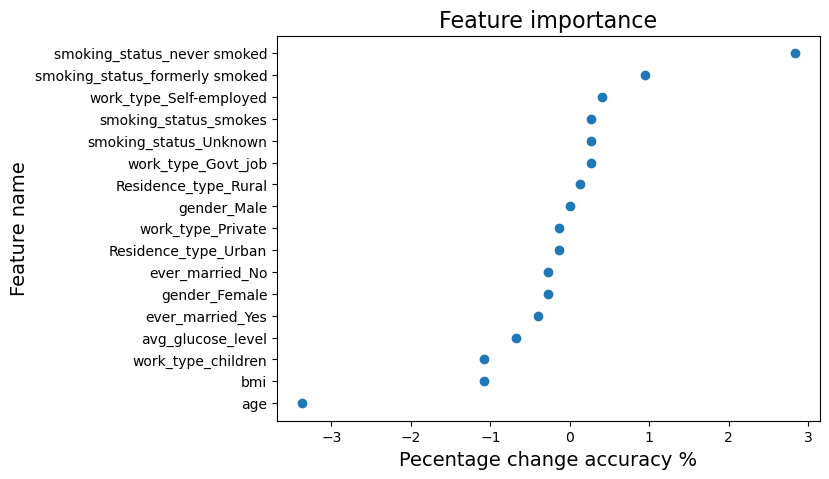

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

df = pd.read_csv("cleaned_data.csv")
df = df.drop("id", axis=1).copy()

#1. Define the model and the preprocess steps
classifier = RandomForestClassifier(n_estimators=500,min_samples_leaf=100)

categorical_columns = df.select_dtypes(include='object').columns.tolist()
numerical_columns = df.select_dtypes(include=['float64']).columns.tolist()

categorical_transformer = OneHotEncoder()
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_columns),
                  ('num',numerical_transformer,numerical_columns)])

#2. Split the data and preprocess the training and test sets separately
y = df['stroke']
X = df.drop('stroke', axis=1)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
X_train_transformed, y_train = SMOTE(random_state=3).fit_resample(X_train_transformed,y_train)

#3. Train the model with the training set and evaluate over the test set
model = classifier.fit(X_train_transformed, y_train)
y_predict = model.predict(X_test_transformed)
 
 
cm = confusion_matrix(y_test, y_predict)
tn, fp, fn, tp = cm.ravel()
df_cm = pd.DataFrame(cm, index=["No stroke", "Stroke"], 
                         columns=["Predicted no stroke", "Predicted stroke"])

print(f"Confusion Matrix with {classifier}:\n", df_cm)
accuracy = (tn+tp)/(tn+fp+ fn+ tp)
precision = (tp)/(tp+fp)
recall = (tp)/(tp+fn)
specificity = (tn) / (tn+fp)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")

#4. Evaluate the feature importance
onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_feature_names = list(onehot_feature_names) + list(numerical_columns)

X_test_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)
acc = metrics.accuracy_score(y_test,y_predict)
score = defaultdict(list)
for column in X_test_df:
    X_shuffle = X_test_df.copy()
    X_shuffle[column] = np.random.permutation(X_shuffle[column].values)
    y_shuffle = model.predict(X_shuffle.values)
    acc_shuffle = metrics.accuracy_score(y_test,y_shuffle)
    score[column].append((acc- acc_shuffle)/acc*100)
    

df_importance = pd.DataFrame({
 'feature': X_test_df.columns,
 'Accuracy decrease': [np.mean(score[column]) for column in X_test_df.columns],
})
df_importance = df_importance.sort_values('Accuracy decrease')

plt.figure(figsize=(7,5))
plt.scatter(df_importance["Accuracy decrease"],df_importance["feature"])
plt.xlabel("Pecentage change accuracy %",size=14)
plt.ylabel("Feature name",size=14)
plt.title("Feature importance",size=16)

Although the RandomForestClassifier presents similar results to the DecisionTreeClassifier, neither model has been fully tuned, making any comparison somewhat premature. However, it is noteworthy that the 'age' variable significantly decreases accuracy when its values are shuffled, underscoring its importance in predicting strokes

### Boosting

Boosting is an ensemble technique that combines multiple weak learners to form a strong predictive model. Each model is trained successively and goals to correct the errors of the preceding one. It exist different boosting algorithms that mainly differ in how the errors are corrected:

* **Adaboost**  
    * This algorithm uses weights to enhance the training on records misclassified in the previous model. This is done either by weighted gini index or weighted sampling. The prediction is made by a weighted averaging of the response of all the models.
* **Gradient boost**
    * Instead of weighted the misclassified records, each model is trained on the errors to the preceding one. Thus, the final prediction is obtained by summing the results of each model.

    These algorithms are versatile and can be both used for classification and regression.

#### Application

* Finance
    * For predicting stock prices, credit scoring, and risk management. Its ability to handle various types of data and capture complex non-linear relationships makes it valuable for financial forecasts.
* Healthcare
    * Used in predicting disease outbreaks, patient prognosis, and other predictive measures in medical diagnostics.

#### Limitation

* Training Time
    * As it is trained sequentuially, the computation cost can be high and drastically increase with the number of model. Each model is built successivly, limition the parallelization.
* Overfitting
    * If not tuned properly, gradient boosting can easily overfit, especially on data with noisy characteristics. 
* Complexity
    * Gradient boosting models can become very complex, making them harder to interpret than simpler models. This complexity can make it difficult to understand the model's decision-making process, which is a significant drawback in fields requiring explainability.
* Hyperparameter Tuning
    * It requires careful tuning of several hyperparameters (such as number of estimators, depth of trees, learning rate, and loss functions), and finding the right settings can be time-consuming and require extensive cross-validation.
* Memory Consumption
    * Gradient boosting can be memory-intensive, as each new tree is built on all the data points in the dataset, which can be challenging to manage with very large datasets.

#### Example 

Here, I will used AdaBoost algorithm to classify patients as having a stroke or not, based on all the features of the dataset. For this, I will use the previously created function 'train_evaluate_model'. 

In [63]:
from sklearn.ensemble import AdaBoostClassifier

df = pd.read_csv("cleaned_data.csv")

_ , model = train_evaluate_model(df, AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                                                        n_estimators=100,
                                                        learning_rate=0.1,
                                                        algorithm='SAMME'
                                                        )
                                 )



Confusion Matrix:
            Predicted no stroke  Predicted stroke
No stroke                  651               288
Stroke                       9                30
Accuracy: 0.70
Precision: 0.09
Recall: 0.77
Specificity: 0.69
